## Introduction.
Barack Obama is left-handed. So are Bill Gates and Oprah Winfrey; so were Babe Ruth and Marie Curie. A 1991 study reported that left-handed people die on average nine years earlier than right-handed people. Nine years! Could this really be true?

In this notebook, we will explore this phenomenon using age distribution data to see if we can reproduce a difference in average age at death purely from the changing rates of left-handedness over time, refuting the claim of early death for left-handers. This notebook uses pandas and Bayesian statistics to analyze the probability of being a certain age at death given that you are reported as left-handed or right-handed.

A National Geographic survey in 1986 resulted in over a million responses that included age, sex, and hand preference for throwing and writing. Researchers Avery Gilbert and Charles Wysocki analyzed this data and noticed that rates of left-handedness were around 13% for people younger than 40 but decreased with age to about 5% by the age of 80. They concluded based on analysis of a subgroup of people who throw left-handed but write right-handed that this age-dependence was primarily due to changing social acceptability of left-handedness. This means that the rates aren't a factor of age specifically but rather of the year you were born, and if the same study was done today, we should expect a shifted version of the same distribution as a function of age. Ultimately, we'll see what effect this changing rate has on the apparent mean age of death of left-handed people, but let's start by plotting the rates of left-handedness as a function of age.

<a name="table_of_contents"></a>
# Content: 

1) [The datasets and importing libraries](#stage_1)

* [Dataset with life expectancy for lefties](#s_1)

* [Dataset with life expectancy data for all people](#s_2)

2) [Getting to the analysis](#stage_2)

3) [Applicability of Bayes' Theorem in the context of the left handed early death hypothesis.](#stage_3)

* [All together, testing the hypothesis through Bayes' theorem](#s_3)

4) [Total probability of death for right-handers and left-handers](#stage_4)

5) [Difference in life expectancy](#stage_5)

6) [Final comments](#stage_6)

<a name="stage_1"></a>
## The datasets and importing libraries
[To the table of contents](#table_of_contents)

In [1]:
! pip install missingno
! pip install matplotlib

In [2]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math
import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno

<a name="s_1"></a>
### Dataset with life expectancy for lefties
[To the table of contents](#table_of_contents)

<p>This notebook uses two datasets: <a href="https://www.cdc.gov/nchs/data/statab/vs00199_table310.pdf">death distribution data</a> for the United States from the year 1999 (source website <a href="https://www.cdc.gov/nchs/nvss/mortality_tables.htm">here</a>) and rates of left-handedness digitized from a figure in this <a href="https://www.ncbi.nlm.nih.gov/pubmed/1528408">1992 paper by Gilbert and Wysocki</a>. </p>

In [3]:
data_url_1 = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
data1 = pd.read_csv(data_url_1)
data1.head(10)

,Age,Male,Female
0,10,12.717558,12.198041
1,11,15.318830,11.144804
2,12,14.808281,11.549240
3,13,13.793744,11.276442
4,14,15.156304,11.572906
5,15,14.086186,12.077731
6,16,14.148993,12.057432
7,17,14.522524,11.524442
8,18,14.727009,12.179550
9,19,15.069371,11.882904


In [4]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     77 non-null     int64  
 1   Male    77 non-null     float64
 2   Female  77 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.9 KB


In [5]:
data1.columns=data1.columns.str.lower()
data1

,age,male,female
0,10,12.717558,12.198041
1,11,15.318830,11.144804
2,12,14.808281,11.549240
3,13,13.793744,11.276442
4,14,15.156304,11.572906
...,...,...,...
72,82,7.350204,4.874899
73,83,6.471204,5.672536
74,84,6.510858,5.774881
75,85,7.337968,7.051459


In [6]:
data1.tail(5)

,age,male,female
72,82,7.350204,4.874899
73,83,6.471204,5.672536
74,84,6.510858,5.774881
75,85,7.337968,7.051459
76,86,5.059387,4.680948


In [7]:
print('Duplicates in dataset:', data1.duplicated().sum())
print('\nMissing values in Dataset:', data1.isna().sum())

Duplicates in dataset: 0

Missing values in Dataset: age       0
male      0
female    0
dtype: int64


<a name="s_2"></a>
### Dataset with life expectancy data for ***all*** people
[To the table of contents](#table_of_contents)

In [8]:
data_url_2 = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"
data2 = pd.read_csv(data_url_2, sep='\t', skiprows=[1])
data2.head(10)


,Age,Both Sexes,Male,Female
0,0,27937.0,15646.0,12291.0
1,1,1989.0,1103.0,886.0
2,2,1376.0,797.0,579.0
3,3,1046.0,601.0,445.0
4,4,838.0,474.0,364.0
5,5,763.0,446.0,317.0
6,6,696.0,384.0,312.0
7,7,683.0,386.0,297.0
8,8,692.0,389.0,303.0
9,9,640.0,359.0,281.0


In [9]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         125 non-null    int64  
 1   Both Sexes  120 non-null    float64
 2   Male        115 non-null    float64
 3   Female      120 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 4.0 KB


In [10]:
print('Duplicates in dataset:', data2.duplicated().sum())
print('\nMissing values in Dataset:', data2.isna().sum())

Duplicates in dataset: 0

Missing values in Dataset: Age            0
Both Sexes     5
Male          10
Female         5
dtype: int64


<AxesSubplot:>

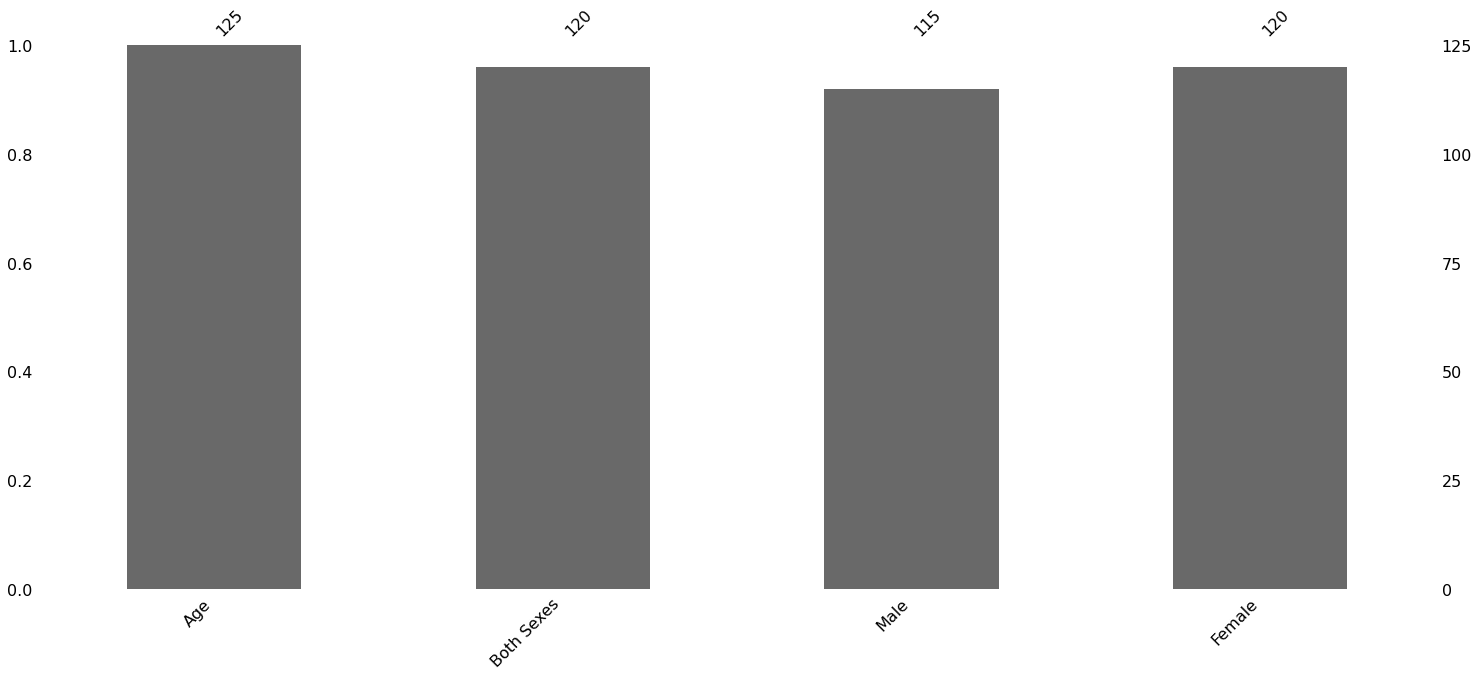

In [11]:
msno.bar(data2)

In [12]:
missing_data = data2.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print(" ")

Age
False    125
Name: Age, dtype: int64
 
Both Sexes
False    120
True       5
Name: Both Sexes, dtype: int64
 
Male
False    115
True      10
Name: Male, dtype: int64
 
Female
False    120
True       5
Name: Female, dtype: int64
 


In [13]:
data2 = data2.dropna(subset = ['Both Sexes'])
data2 = data2.dropna(subset = ['Male'])
print('Missing values in dataset:', data2.isna().sum())

Missing values in dataset: Age           0
Both Sexes    0
Male          0
Female        0
dtype: int64


I'll lower the case for ease of interaction, and then replace the name "both sexes" with "death", because more suitable in meaning and convenient to refer to the column

In [14]:
data2.columns=data2.columns.str.lower()
data2.rename(columns={'both sexes':'deaths'}, inplace=True)
data2

,age,deaths,male,female
0,0,27937.0,15646.0,12291.0
1,1,1989.0,1103.0,886.0
2,2,1376.0,797.0,579.0
3,3,1046.0,601.0,445.0
4,4,838.0,474.0,364.0
...,...,...,...,...
110,110,40.0,9.0,31.0
111,111,21.0,1.0,20.0
112,112,12.0,2.0,10.0
113,113,9.0,2.0,7.0


<a name="stage_2"></a>
## Getting to the analysis
[To the table of contents](#table_of_contents)

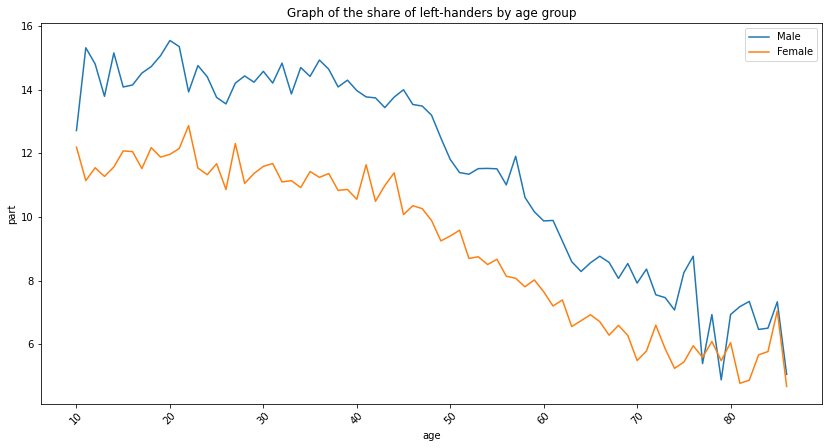

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(data1['age'], data1['male'], label='Male')
plt.plot(data1['age'], data1['female'], label='Female')
plt.title('Graph of the share of left-handers by age group')
plt.ylabel('part')
plt.xlabel('age')
plt.xticks(rotation=45)
plt.legend()
plt.show()    

No handles with labels found to put in legend.


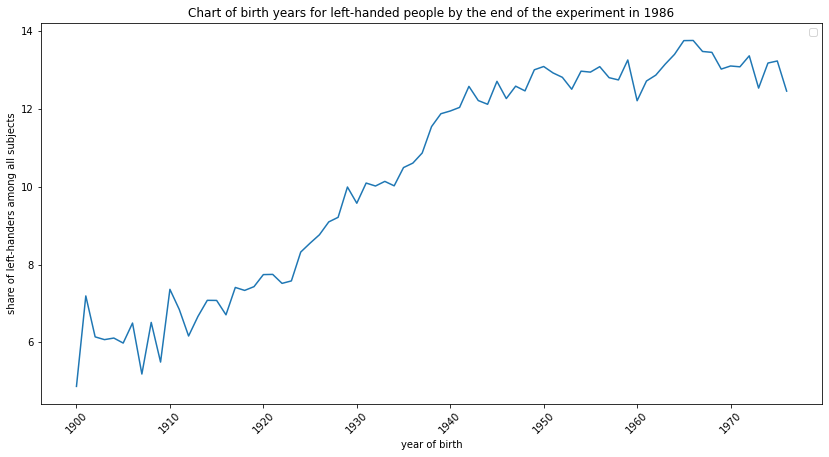

In [16]:
#the experiment was conducted in 1986, so we calculate the age of the subjects at the time of the experiment
data1['birth_date'] = 1986 - data1['age'] 
data1['mean_lh'] = data1[['female', 'male']].mean(axis=1)

plt.figure(figsize=(14, 7))
plt.plot(data1['birth_date'], data1['mean_lh'])
plt.title('Chart of birth years for left-handed people by the end of the experiment in 1986')
plt.ylabel('share of left-handers among all subjects')
plt.xlabel('year of birth')
plt.xticks(rotation=45)
plt.legend()
plt.show()  

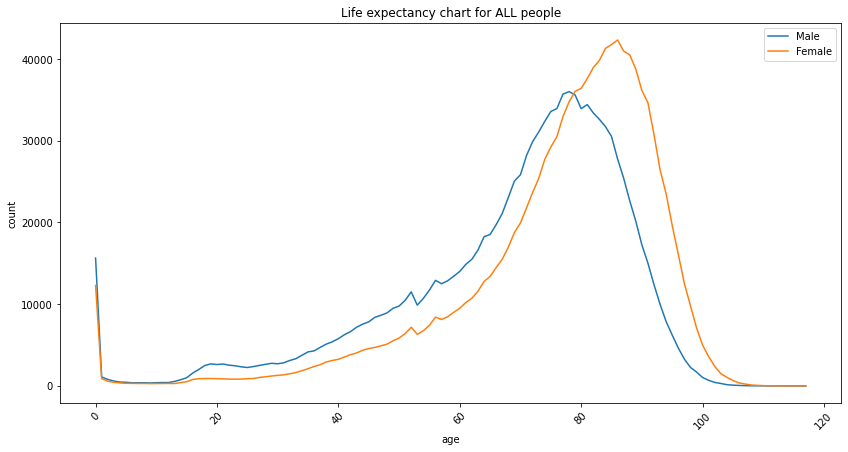

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(data2['age'], data2['male'], label='Male')
plt.plot(data2['age'], data2['female'], label='Female')
plt.title('Life expectancy chart for ALL people')
plt.ylabel('count')
plt.xlabel('age')
plt.xticks(rotation=45)
plt.legend()
plt.show()    

<a name="stage_3"></a>
## Applicability of Bayes' Theorem in the context of the left handed early death hypothesis.
[To the table of contents](#table_of_contents)

Bayes' theorem allows you to determine the probability of an event, provided that another event that is statistically interdependent with it has occurred. By itself, the probability of dying at a certain age, given that you are left-handed, is not the same as the probability of being left-handed, provided that you die at a certain age. That is, in the condition of Bayes' theorem, Being left-handed is a condition of observations, ie P(E). Death is the overall probability of dying at age H, i.e. P(H).


Bayes' theorem in such a context will help to renew beliefs upon seeing evidence.

You need to calculate the probability of dying at age H, given the observable condition that you are left-handed - E. The formula will look like this:

<p>$$P(H | E) = \frac{P(E|H) P(H)}{P(EH)}$$</p>

Where the terms P(E|H) is the probability that you are left-handed, given that you died at age H.

#### Write a function to calculate the condition P(E|H)
There are certain conditions here in the two datasets: Left-handed age data range from 10 to 86 years. Age at death data range from 1 to 120 years. Therefore, it is necessary to find the left-handed age values for the missing ages, i.e. 1 to 9 and 87 to 120 age groups as the average of the last 5 and first 5 age records in the data1 dataset.

For ages 10 to 86, this score would be the same as the left-handed age dataset.

Then the desired probability will be equal to the corresponding indicator for age, divided by 100 (since the indicator is indicated in%).

###### Note:
Since to calculate this condition, you need to extrapolate data to earlier and later years, based on the data1 dataset, the dates of the beginning and end of the 1900s. will be taken from the calculation of average values, because at the starting and ending points of the 1900s. the data is aligned and looks homogeneous, so 5 adjacent averages to them will be taken (from the logic of strictness to significance).

In [18]:
#the variable study_year denotes the year of the experiment, before 1990 was already indicated as the date of the search for the age of the subjects
def P_E_H (death_age, study_year = 1990):
    rate_start = data1['mean_lh'][-5:].mean()
    rate_end = data1['mean_lh'][:5].mean()
    rate_mid = data1.loc[data1['age'].isin(death_age)]['mean_lh']
    
    #in the dataset data1, the youngest is 10 years old, the oldest is 86
    youngest_value = study_year - 1986 + 10 
    oldest_value = study_year - 1986 + 86 
    
    #empty array to store results
    p_return = np.zeros(death_age.shape)
    
    #indicators of the number of lefties in the ages "death_age"
    p_return[death_age>oldest_value]=rate_start/100
    p_return[death_age<youngest_value]=rate_end/100
    p_return[np.logical_and((death_age <= oldest_value), (death_age >= youngest_value))] = rate_mid / 100
    
    return p_return
    
    

#### Total probability that a person who died at age H was left-handed - P(E)


P(E) is the probability that a person who died in our particular study year is left-handed, assuming we don't know anything else about them.

This is the average left-handedness in the death statistics, and can be calculated by summing all the left-handedness probabilities for each age, weighted by the number of people who died at each age, and then dividing by the total number of people who died to get the probability.

In [19]:
def P_LH(data2, study_year=1990): 
    
    # summing all the lefts for each age:
    
    #1. The product of the number of deaths by the probability that you are left-handed, given that you died at age H.
    p_list = data2['deaths'] * P_E_H(data2['age'])
    
    #2. Amount on the list
    p = sum(p_list)
    
    #3.Order to the total number of people in the dataset
    return p / np.sum(data2['deaths'])

print('probability that a person who died at age H was left-handed:', P_LH(data2))

probability that a person who died at age H was left-handed: 0.07771931564770244


<a name="s_3"></a>
### All together, testing the hypothesis through Bayes' theorem
[To the table of contents](#table_of_contents)

Now there are all the necessary variables to test Bayes' theorem: P(H|E) = P(E|H)*P(E) // P(E).

We combine variables to find P(H|E) - the probability of reaching age A at the time of death (in the studied period of time), given that you are left-handed. As a confirmation of the theory about the early death of left-handers, we will do the same for right-handers.

left-handers

In [20]:
def P_A_LH(death_age, data2, study_year=1990):
    P_A = data2['deaths'][death_age] / np.sum(data2['deaths'])
    P_left = P_LH(data2, study_year)
    P_left_age = P_E_H(death_age, study_year)
    
    return P_left_age*P_A/P_left

right-handers

In [21]:
def P_A_RH(death_age, data2, study_year=1990):
    P_A = data2['deaths'][death_age] / np.sum(data2['deaths'])
    P_right = 1-P_LH(data2, study_year)
    P_right_age = 1-P_E_H(death_age, study_year)
    
    return P_right_age*P_A/P_right

<a name="stage_4"></a>
## Total probability of death for right-handers and left-handers
[To the table of contents](#table_of_contents)

In [22]:
ages = data2.age
left_handed_probability = P_A_LH(ages, data2)
right_handed_probability = P_A_RH(ages, data2)

Text(0, 0.5, 'Probability of being age A at death')

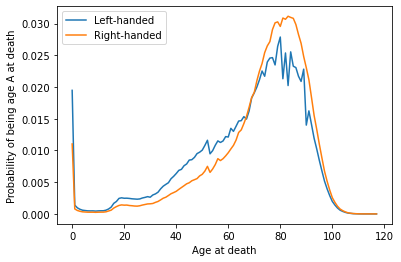

In [23]:
fig, ax = plt.subplots() # create figure and axis objects
ax.plot(ages, left_handed_probability, label = "Left-handed")
ax.plot(ages, right_handed_probability, label = "Right-handed")
ax.legend()
ax.set_xlabel("Age at death")
ax.set_ylabel("Probability of being age A at death")

<a name="stage_5"></a>
## Difference in life expectancy
[To the table of contents](#table_of_contents)

In [24]:
average_lh_age =  np.nansum(ages*np.array(left_handed_probability))
average_rh_age =  np.nansum(ages*np.array(right_handed_probability))

print('Average life expectancy for lefties:', average_lh_age)
print('----------------------------------------------------- --------')
print('Average life expectancy for right-handed people:', average_rh_age)

Average life expectancy for lefties: 67.30209241077102
----------------------------------------------------- --------
Average life expectancy for right-handed people: 72.79434330559559


In [25]:
print("Difference in average ages " + str(round(average_rh_age - average_lh_age, 1)) + " years.")

Difference in average ages 5.5 years.


<a name="stage_6"></a>
## Final comments
[To the table of contents](#table_of_contents)
<p>We got a pretty big age gap between left-handed and right-handed people purely as a result of the changing rates of left-handedness in the population, which is good news for left-handers: you probably won't die young because of your sinisterness. The reported rates of left-handedness have increased from just 3% in the early 1900s to about 11% today, which means that older people are much more likely to be reported as right-handed than left-handed, and so looking at a sample of recently deceased people will have more old right-handers.</p>
<p>Our number is still less than the 9-year gap measured in the study. It's possible that some of the approximations we made are the cause: </p>
<ol>
<li>We used death distribution data from almost ten years after the study (1999 instead of 1991), and we used death data from the entire United States instead of California alone (which was the original study). </li>
<li>We extrapolated the left-handedness survey results to older and younger age groups, but it's possible our extrapolation wasn't close enough to the true rates for those ages. </li>
</ol>
<p>One thing we could do next is figure out how much variability we would expect to encounter in the age difference purely because of random sampling: if you take a smaller sample of recently deceased people and assign handedness with the probabilities of the survey, what does that distribution look like? How often would we encounter an age gap of nine years using the same data and assumptions? We won't do that here, but it's possible with this data and the tools of random sampling. </p>